# TAKE PROFIT & STOP LOSS CALCULATE

In [17]:
import time
from turtle import back
import pandas as pd
import numpy as np
from datetime import timedelta, datetime


def ledger(signals, df,time_frame='4H'):
    """
    This function takes a dataframe of signals which is 4h interval data and df which is 1min interval data.
    """
    signals = signals
    df_1min = df
    action = []
    signal = []
    date_time = []
    buy_price = []
    sell_price = []
    pnl = []
    balance = 1000
    transaction_fee = 0.07 / 100
    profit_percentage = 0.05
    stop_loss_percentage = 0.02
    next_trade_time = None  # To store the time of the next trade
    def calculate_levels(buy, direction):
        if direction == 1:
            tp_price = buy + (buy * profit_percentage)
            sl_price = buy - (buy * stop_loss_percentage)
        elif direction == -1:
            tp_price = buy - (buy * profit_percentage)
            sl_price = buy + (buy * stop_loss_percentage)
        else:
            tp_price = sl_price = np.nan
        return tp_price, sl_price
    for i in range(len(signals)):
        if len(action) == 0 or (next_trade_time is not None and signals['timestamp'][i] >= next_trade_time):
            # Check and open a trade in the signal's direction
            if signals['rsi_signal'][i] != 0:
                action.append(signals['rsi_signal'][i])
                date_time.append(signals['timestamp'][i])
                buy_price.append(signals['open'][i])
                buy = signals['open'][i]
                if signals['rsi_signal'][i]==1:
                    signal.append('Buy')
                elif signals['rsi_signal'][i]==-1:
                    signal.append('Sell')
                sell_price.append(np.nan)
                pnl.append(np.nan)
                next_trade_time = None
                tp_price, sl_price = calculate_levels(buy, signals['rsi_signal'][i])
        else:
            if action[-1] == signals.iloc[i].rsi_signal or signals['rsi_signal'][i] == 0:
                if action[-1] == 1:
                    tp_price, sl_price = calculate_levels(buy, 1)
                elif action[-1] == -1:
                    tp_price, sl_price = calculate_levels(buy, -1)
                else:
                    continue  # Skip if signal is neither 1 nor -1
                # Ensure we do not go out of bounds
                if i + 1 < len(signals):
                    next_signal_date = signals.loc[i + 1, 'timestamp']
                else:
                    next_signal_date = df_1min['timestamp'].max()
                end_datetime = signals.iloc[i]['timestamp']
                current_datetime = end_datetime - timedelta(hours=int(time_frame[0]))
                df_1min_slice = df_1min[(df_1min['timestamp'] >= current_datetime) & (df_1min['timestamp'] <= end_datetime)]
                df_1min_slice.reset_index(drop=True,inplace=True)
                for j in df_1min_slice.iterrows():
                    if j[1].high > tp_price and action[-1] == 1:
                        # Take profit
                        time = j[1].timestamp
                        sell_price.append(j[1].high)
                        action.append(action[-1])
                        signal.append('TP Hit')
                        date_time.append(time)
                        buy_price.append(np.nan)
                        pnl.append(np.nan)
                        next_trade_time = (pd.to_datetime(time) + pd.Timedelta(hours=(int(time_frame[0]) - pd.to_datetime(time).hour % 4))).replace(minute=0, second=0, microsecond=0)
                        break
                    elif j[1].low < sl_price and action[-1] == 1:
                        # Stop loss
                        time = j[1].timestamp
                        sell_price.append(j[1].low)
                        signal.append('SL Hit')
                        action.append(action[-1])
                        date_time.append(time)
                        buy_price.append(np.nan)
                        pnl.append(np.nan)
                        next_trade_time = (pd.to_datetime(time) + pd.Timedelta(hours=(int(time_frame[0]) - pd.to_datetime(time).hour % 4))).replace(minute=0, second=0, microsecond=0)
                        break
                    elif j[1].low < tp_price and action[-1] == -1:
                        # Take profit
                        time = j[1].timestamp
                        sell_price.append(j[1].low)
                        action.append(action[-1])
                        signal.append('TP Hit')
                        date_time.append(time)
                        buy_price.append(np.nan)
                        pnl.append(np.nan)
                        next_trade_time = (pd.to_datetime(time) + pd.Timedelta(hours=(int(time_frame[0]) - pd.to_datetime(time).hour % 4))).replace(minute=0, second=0, microsecond=0)
                        break
                    elif j[1].high > sl_price and action[-1] == -1:
                        # Stop loss
                        time = j[1].timestamp
                        sell_price.append(j[1].high)
                        action.append(action[-1])
                        signal.append('SL Hit')
                        date_time.append(time)
                        buy_price.append(np.nan)
                        pnl.append(np.nan)
                        next_trade_time = (pd.to_datetime(time) + pd.Timedelta(hours=(int(time_frame[0]) - pd.to_datetime(time).hour % 4))).replace(minute=0, second=0, microsecond=0)
                        break
            else:
                # Close the previous trade due to trend change
                if action[-1] in ['tp hit', 'sl hit']:
                    if signals['rsi_signal'][i] == 0:
                        continue  # Ignore if the new signal is 0
                    action.append(signals['rsi_signal'][i])
                    date_time.append(signals['timestamp'][i])
                    buy_price.append(signals['open'][i])
                    signal.append('Buy')
                    buy = signals['open'][i]
                    sell_price.append(np.nan)
                    pnl.append(np.nan)
                    next_trade_time = None
                else:
                    action.append(signals['rsi_signal'][i])
                    date_time.append(signals['timestamp'][i])
                    sell_price.append(signals['open'][i])
                    buy = signals['open'][i]
                    if signals['rsi_signal'][i]==1:
                        signal.append('Buy')
                    elif signals['rsi_signal'][i]==-1:
                        signal.append('Sell')
                    # signal.append(np.nan)
                    buy_price.append(np.nan)
                    pnl.append(np.nan)

                    action.append(signals['rsi_signal'][i])
                    date_time.append(signals['timestamp'][i])
                    buy_price.append(signals['open'][i])
                    buy = signals['open'][i]
                    if signals['rsi_signal'][i]==1:
                        signal.append('Buy')
                    elif signals['rsi_signal'][i]==-1:
                        signal.append('Sell')
                    sell_price.append(np.nan)
                    pnl.append(np.nan)
    # Creating the resulting dataframe
    ledger_df = pd.DataFrame({
        'date_time': date_time,
        'action': action,
        'signal': signal,
        'buy_price': buy_price,
        'sell_price': sell_price,
        'pnl': pnl
    })
    ledger_df['buy_price'] = ledger_df['buy_price'].fillna(method='ffill')
    def calculate_pnl(df):
        balance = 1000
        df['balance'] = np.nan
        for index, row in df.iterrows():
            buy_price = float(row['buy_price'])
            sell_price = float(row['sell_price'])
            signal = row['action']
            if pd.isna(sell_price) or pd.isna(buy_price):
                if index == 0:
                    df.at[index, 'balance'] = balance
                else:
                    df.at[index, 'balance'] = df.iloc[index-1]['balance']
                continue
            if df.iloc[index-1]['action'] == 1:  # Long
                pnl_percent = ((sell_price - buy_price) / buy_price) * 100
                balance += balance * (pnl_percent / 100) - transaction_fee
                df.at[index, 'balance'] = balance
            elif df.iloc[index-1]['action'] == -1:  # Short
                pnl_percent = ((buy_price - sell_price) / buy_price) * 100
                balance += balance * (pnl_percent / 100) - transaction_fee
                df.at[index, 'balance'] = balance
                
                
            else:
                pnl_percent = 0
            pnl_percent -= transaction_fee * 100
            df.at[index, 'pnl'] = round(pnl_percent, 2)  # Efficient assignment

        return df

    ledger_df = calculate_pnl(ledger_df)

    return ledger_df


# Read CSV

In [14]:
import pandas as pd
from datetime import timedelta


signals = pd.read_csv('signals_4h_.csv', parse_dates=['timestamp'])[['timestamp','open', 'high', 'low', 'close', 'rsi_signal']]
df = pd.read_csv('ohlc_1m_data_last_day.csv', parse_dates=['timestamp'])


# FUNCTION CALL

In [18]:

ledger_df = ledger(signals, df)

C:\Users\MTariq\AppData\Local\Temp\ipykernel_12340\2371079590.py:158: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ledger_df['buy_price'] = ledger_df['buy_price'].fillna(method='ffill')


In [20]:
ledger_df.head(30)

,date_time,action,signal,buy_price,sell_price,pnl,balance
0,2020-01-01 00:00:00,1,Buy,7181.06,NaN,NaN,1000.000000
1,2020-01-01 04:00:00,-1,Sell,7181.06,7219.43,0.46,1005.342522
2,2020-01-01 04:00:00,-1,Sell,7219.43,NaN,NaN,1005.342522
3,2020-01-01 08:00:00,1,Buy,7219.43,7206.44,0.11,1007.150746
4,2020-01-01 08:00:00,1,Buy,7206.44,NaN,NaN,1007.150746
5,2020-01-01 20:00:00,-1,Sell,7206.44,7231.35,0.28,1010.631394
6,2020-01-01 20:00:00,-1,Sell,7231.35,NaN,NaN,1010.631394
7,2020-01-02 00:00:00,1,Buy,7231.35,7192.87,0.46,1016.008541
8,2020-01-02 00:00:00,1,Buy,7192.87,NaN,NaN,1016.008541
9,2020-01-02 12:00:00,-1,Sell,7192.87,7156.11,-0.58,1010.815411


In [23]:
ledger_df.to_csv (r'tp_sl_hit.csv',index = True)

# COORELATION


C:\Users\MTariq\AppData\Local\Temp\ipykernel_12340\2371079590.py:158: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ledger_df['buy_price'] = ledger_df['buy_price'].fillna(method='ffill')


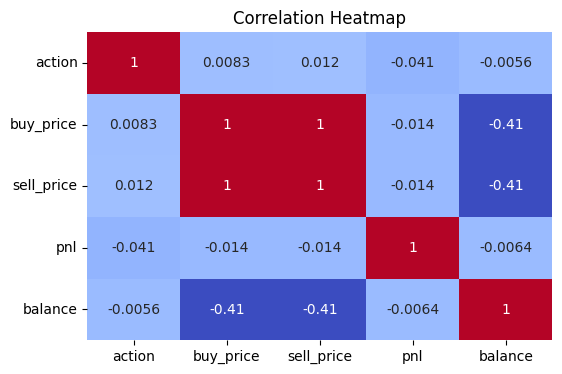

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
def visualize_correlation(ledger_df):
    numeric_df = ledger_df.select_dtypes(include=[np.number])
    if numeric_df.shape[1] == 0:
        print("No numeric columns to correlate.")
        return 
    plt.figure(figsize=(6, 4))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', cbar=False)
    plt.title('Correlation Heatmap')
    plt.show()
signals = pd.read_csv('signals_4h_.csv', parse_dates=['timestamp'])
df_1min = pd.read_csv('ohlc_1m_data_last_day.csv', parse_dates=['timestamp'])
processed_ledger = ledger(signals, df_1min, time_frame='4H')
visualize_correlation(processed_ledger)
